# Netflix Movie Recommendation System

Credits: <src href = "https://www.netflixprize.com/rules.html">Netflix Prize</src>

<p>
Netflix is the world’s leading Internet television network and the most-valued largest streaming service in the world.However the amazing digital success story of Netflix is incomplete without the mention of its recommender systems that focus on personalization.Personalization begins on Netflix’s homepage that shows group of videos arranged in horizontal rows. Each horizontal row has a title which relates to the videos in that group. Most of the personalized recommendations begin based on the way rows are selected and the order in which the items are placed. Recommender systems at Netflix span various algorithmic approaches like reinforcement learning, neural networks, causal modelling, probabilistic graphical models, matrix factorization, ensembles, bandits. <br>
    
Netflix had developed a movie recommendation system: CinematchSM. Its job is to predict whether someone will enjoy a movie based on how much they liked or disliked other movies.Cinematch uses "straightforward statistical linear models with a lot of data conditioning". And while Cinematch is doing pretty well, it can always be made better.Using only the training data, Cinematch scores an RMSE of 0.9514 on the quiz data and a similar performance on the test set, 0.9525</p>


<p><b>This case study is done with the motivation of learning how a recommendation system works by taking some of the knowledge already presented in the literature and attempting to implement some new ideas if it is possible to attain a better RMSE score than that obatined with Cinematch.However due to computation limitation, i am taking only a fraction of the total data provided in Netflix Prize data</b></p>

<br>
<br>

<p><b>The objectives of this case study and how we map those to a Machine Learning problem :</b></p> 

1. To predict the rating that a customer would give to a movie that he has not yet rated.For a given movie and user we need to predict the rating.This recommendation problem can also seen as a Regression problem <br>

2.	To minimize the difference between predicted and actual rating.The performance metrics used are Mean Absolute Percentage Error(MAPE) and Root Mean Square Error(RMSE)

3. While achieving the objectives we also need to mantain some form of interpretability.

<p><b>Data Overview</b></p>

Files: 
1. combined_data_1.txt
2. <b>combined_data_2.txt</b>
3. combined_data_3.txt
4. combined_data_4.txt
5. movie_titles.csv

However as already mentioned, due to computation and memory limitation we take only data from  one file(combined_data_2.txt) as our taining data.
The first line of the file contains the movie id followed by a colon. Each subsequent line in the file corresponds to a customerID, rating from a customer and its date.

<h3>Sources</h3>

1. https://www.netflixprize.com/rules.html<br>
2. https://www.kaggle.com/netflix-inc/netflix-prize-data
* Netflix blog: https://medium.com/netflix-techblog/netflix-recommendations-beyond-the-5-stars-part-1-55838468f429 (very nice blog)
* surprise library: http://surpriselib.com/ (we use many models from this library)
* surprise library doc: http://surprise.readthedocs.io/en/stable/getting_started.html (we use many models from this library)
* installing surprise: https://github.com/NicolasHug/Surprise#installation
* Research paper: http://courses.ischool.berkeley.edu/i290-dm/s11/SECURE/a1-koren.pdf (most of our work was inspired by this paper)
* SVD Decomposition : https://www.youtube.com/watch?v=P5mlg91as1c

In [3]:
from datetime import datetime
import time
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
import os
import random
import matplotlib
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error


import xgboost as xgb
from surprise import Reader, Dataset
from surprise import BaselineOnly
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp
from surprise.model_selection import GridSearchCV

## 1. Reading and Storing Data

### 1.1. Data Pre-processing

In [2]:
if not os.path.isfile("temp_files/netflixData.csv"):
    data = open("temp_files/netflixData.csv", mode = "w")
    file = '../data_folder/combined_data_2.txt'
    with open(file) as f: 
        for line in f:
            line = line.strip() 
            if line.endswith(":"):
                movieID = line.replace(":", "")
            else:
                #Creating csv file with movieID,customerID,rating and date
                csv_row = line.split(",")
                csv_row.insert(0, movieID)
                data.write(",".join(csv_row))
                data.write("\n")
    data.close()
    data = pd.read_csv("temp_files/netflixData.csv", sep=",", names = ["MovieID","CustID", "Ratings", "Date"])
    data["Date"] = pd.to_datetime(data_final["Date"])
    data.sort_values(by = "Date", inplace = True)
    data.to_pickle("temp_files/NetflixData.pkl")
else:
    data = pd.read_pickle("temp_files/NetflixData.pkl")

In [3]:
print(data.head())
print("*"*100)
print("Basis statistics of Ratings")
print("*"*100)
print(data.describe()["Ratings"])

          MovieID  CustID  Ratings       Date
6465113      5571  510180        4 1999-11-11
21262258     8079  510180        2 1999-11-11
13151644     6615  510180        5 1999-11-11
24047847     8651  510180        2 1999-11-11
22463125     8357  510180        4 1999-11-11
****************************************************************************************************
Basis statistics of Ratings
****************************************************************************************************
count    2.697759e+07
mean     3.589280e+00
std      1.084677e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: Ratings, dtype: float64


### 1.2 Checking for Missing values

In [4]:
print(data.isnull().sum())

MovieID    0
CustID     0
Ratings    0
Date       0
dtype: int64


In [112]:
data.head()

,MovieID,CustID,Ratings,Date
6465113,5571,510180,4,1999-11-11
21262258,8079,510180,2,1999-11-11
13151644,6615,510180,5,1999-11-11
24047847,8651,510180,2,1999-11-11
22463125,8357,510180,4,1999-11-11


### 1.3 Removing Duplicates

In [5]:
duplicates = data.duplicated(["MovieID","CustID", "Ratings"])
print("Number of duplicate rows = "+str(duplicates.sum()))

Number of duplicate rows = 0



### 1.4 Basic Statistics

In [6]:
print("Total Data:")
print("Total number of movie ratings = "+str(data.shape[0]))
print("Number of unique users = "+str(len(np.unique(data["CustID"]))))
print("Number of unique movies = "+str(len(np.unique(data["MovieID"]))))

Total Data:
Total number of movie ratings = 26977591
Number of unique users = 474062
Number of unique movies = 4711


### 1.5 Spliting data into Train and Test(80:20)

In [7]:
if not os.path.isfile("temp_files/train.pkl"):
    data.iloc[:int(data.shape[0]*0.80)].to_pickle("temp_files/train.pkl")
else:
    train_data = pd.read_pickle("temp_files/train.pkl")
    train_data.reset_index(drop = True, inplace = True)

if not os.path.isfile("temp_files/test.pkl"):
    data.iloc[int(data.shape[0]*0.80):].to_pickle("temp_files/test.pkl")
else:
    test_data = pd.read_pickle("temp_files/test.pkl")
    test_data.reset_index(drop = True, inplace = True)

### 1.6 Basic Statistics in Train and Test data

In [8]:
print("Total number of movie ratings in train data = "+str(train_data.shape[0]))
print("Number of unique users in train data = "+str(len(np.unique(train_data["CustID"]))))
print("Number of unique movies in train data = "+str(len(np.unique(train_data["MovieID"]))))

print("*"*100)

print("Total number of movie ratings in test data = "+str(test_data.shape[0]))
print("Number of unique users in test data = "+str(len(np.unique(test_data["CustID"]))))
print("Number of unique movies in test data = "+str(len(np.unique(test_data["MovieID"]))))

Total number of movie ratings in train data = 21582072
Number of unique users in train data = 393933
Number of unique movies in train data = 4605
****************************************************************************************************
Total number of movie ratings in test data = 5395519
Number of unique users in test data = 302565
Number of unique movies in test data = 4706


In [9]:
print("Highest value of a User ID = "+str(max(train_data["CustID"].values)))
print("Highest value of a Movie ID = "+str(max(train_data["MovieID"].values)))

Highest value of a User ID = 2649429
Highest value of a Movie ID = 9210


## 2. Exploratory Data Analysis on Train Data

### 2.1 Distribution of ratings

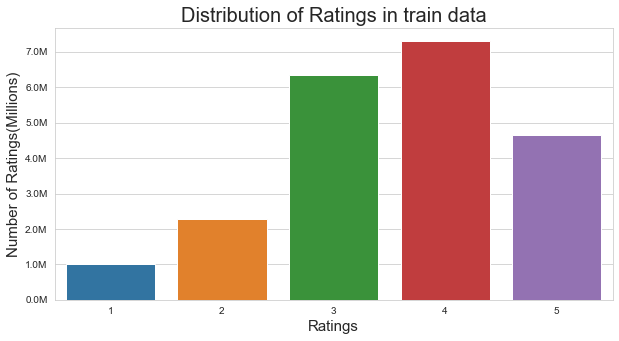

In [10]:
def changing_labels(no):
    return str(no/10**6) + "M"

plt.figure(figsize = (10, 5))
ax = sns.countplot(x = "Ratings", data = train_data)
ax.set_yticklabels([changing_labels(num) for num in ax.get_yticks()])

plt.title("Distribution of Ratings in train data", fontsize = 20)
plt.xlabel("Ratings", fontsize = 15)
plt.ylabel("Number of Ratings(Millions)", fontsize = 15)
plt.show()

In [11]:
train_data["day_of_week"] = train_data.Date.dt.strftime("%A")

### 2.2 Number of Ratings per month for  years 2000 to 2006

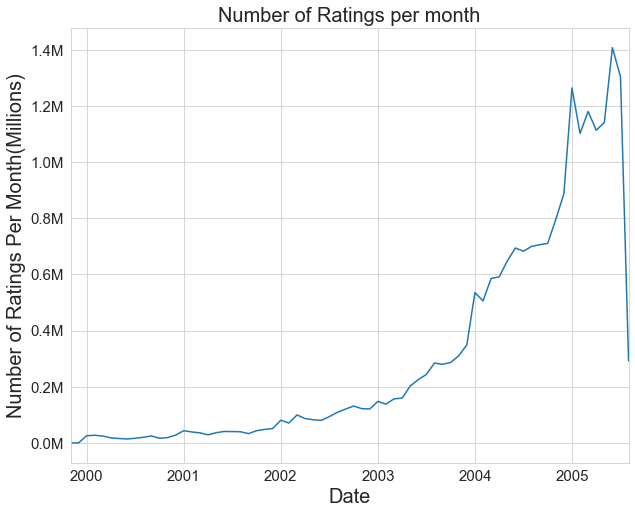

In [12]:
plt.figure(figsize = (10,8))
ax = train_data.resample("M", on = "Date")["Ratings"].count().plot() #Counts of ratings monthly

ax.set_yticklabels([changing_labels(num) for num in ax.get_yticks()])
ax.set_title("Number of Ratings per month", fontsize = 20)
ax.set_xlabel("Date", fontsize = 20)
ax.set_ylabel("Number of Ratings Per Month(Millions)", fontsize = 20)
plt.tick_params(labelsize = 15)
plt.show()

###  2.3 Analysis of Ratings  by User

In [13]:
rated_movies_per_user = train_data.groupby(by = "CustID")["Ratings"].count().sort_values(ascending = False)
rated_movies_per_user.describe()

count    393933.000000
mean         54.786149
std          79.907844
min           1.000000
25%           9.000000
50%          25.000000
75%          68.000000
max        4544.000000
Name: Ratings, dtype: float64

The minimum ratings per user is around 55, but the maximum is 4544 which is very high;seems to be outliers.

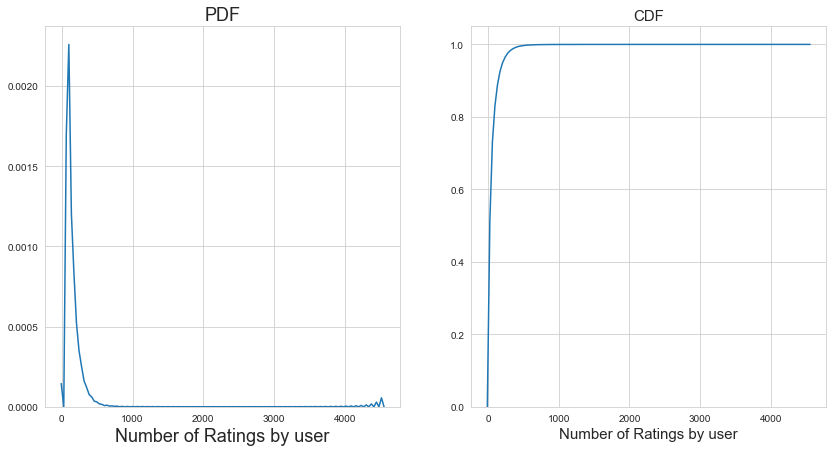

In [14]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(14,7))

sns.kdeplot(rated_movies_per_user.values,  ax = axes[0])
axes[0].set_title("PDF", fontsize = 18)
axes[0].set_xlabel("Number of Ratings by user", fontsize = 18)

sns.kdeplot(rated_movies_per_user.values, cumulative = True, ax = axes[1])
axes[1].set_title("CDF", fontsize = 15)
axes[1].set_xlabel("Number of Ratings by user", fontsize = 15)

plt.show()

* Above PDF graph shows that almost all of the users give very few ratings. There are very few users who's ratings count is high.
* Similarly, above CDF graph shows that almost 99% of users give very few ratings.

##### Checking outliers

In [15]:
for i in np.arange(0,1.01,0.1):
    print("{} quantile value is {}".format(np.round(i,2),rated_movies_per_user.quantile(i)))

0.0 quantile value is 1.0
0.1 quantile value is 4.0
0.2 quantile value is 8.0
0.3 quantile value is 12.0
0.4 quantile value is 17.0
0.5 quantile value is 25.0
0.6 quantile value is 37.0
0.7 quantile value is 55.0
0.8 quantile value is 85.0
0.9 quantile value is 144.0
1.0 quantile value is 4544.0


In [16]:
for i in np.arange(0.9,1.01,0.01):
    print("{} quantile value is {}".format(np.round(i,2),rated_movies_per_user.quantile(i)))

0.9 quantile value is 144.0
0.91 quantile value is 153.0
0.92 quantile value is 163.0
0.93 quantile value is 175.0
0.94 quantile value is 190.0
0.95 quantile value is 207.0
0.96 quantile value is 229.0
0.97 quantile value is 258.0
0.98 quantile value is 298.0
0.99 quantile value is 370.0
1.0 quantile value is 4544.0


In [17]:
print("Total number of ratings per user below 99th percentile = "+str(sum(rated_movies_per_user.values<=370.0)))
print("Total number of ratings per user above 99th percentile = "+str(sum(rated_movies_per_user.values>370.0)))

Total number of ratings per user below 99th percentile = 389998
Total number of ratings per user above 99th percentile = 3935


So, 99% of users gave less than 370 ratings.

### 2.4 Analysis of Ratings by Movie

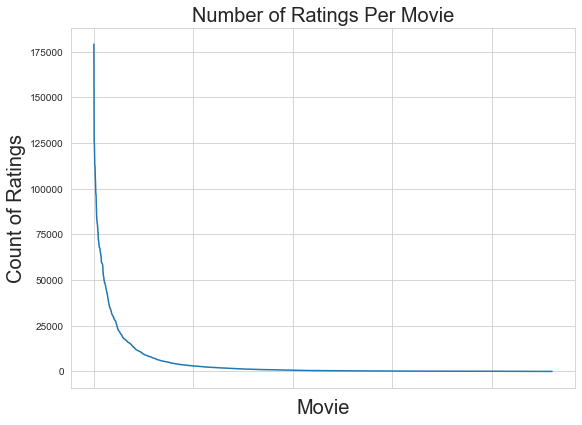

In [18]:
ratings_per_movie = train_data.groupby(by = "MovieID")["Ratings"].count().sort_values(ascending = False)

fig = plt.figure(figsize = (7, 5))
axes = fig.add_axes([0.1,0.1,1,1])
plt.title("Number of Ratings Per Movie", fontsize = 20)
plt.xlabel("Movie", fontsize = 20)
plt.ylabel("Count of Ratings", fontsize = 20)
plt.plot(ratings_per_movie.values)

axes.set_xticklabels([])
plt.show()

<b>It is very skewed</b>
<p>It clearly shows that there are some movies which are very popular and were rated by many users as comapared to other movies</p>

### 2.5. Analysis of Movie Ratings on Day of Week

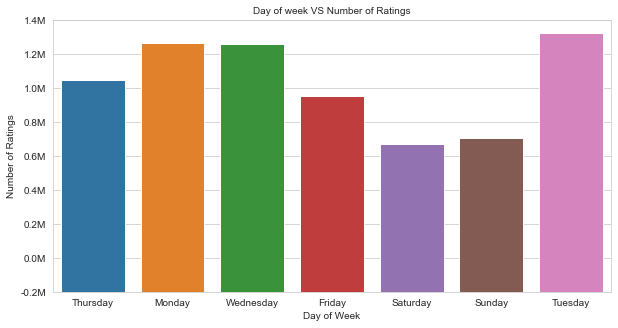

In [19]:
fig = plt.figure(figsize = (10, 5))

axes = sns.countplot(x = "day_of_week", data = train_data)
axes.set_title("Day of week VS Number of Ratings", fontsize = 10)
axes.set_xlabel("Day of Week", fontsize = 10)
axes.set_ylabel("Number of Ratings", fontsize = 10)
axes.set_yticklabels([changing_labels(num) for num in ax.get_yticks()])
axes.tick_params(labelsize = 10)

plt.show()

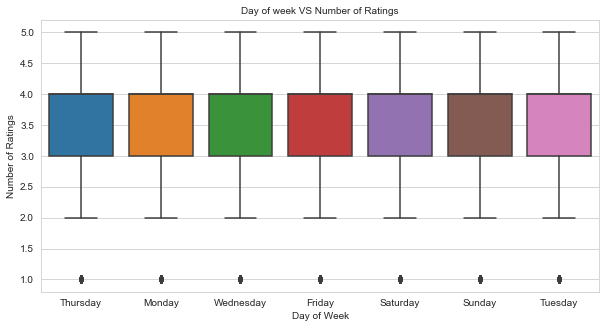

In [20]:
fig = plt.figure(figsize = (10, 5))

axes = sns.boxplot(x = "day_of_week", y = "Ratings", data = train_data)
axes.set_title("Day of week VS Number of Ratings", fontsize = 10)
axes.set_xlabel("Day of Week", fontsize = 10)
axes.set_ylabel("Number of Ratings", fontsize = 10)
axes.tick_params(labelsize = 10)

plt.show()

### 2.6 Average rating on week days

In [21]:
average_ratings_dayofweek = train_data.groupby(by = "day_of_week")["Ratings"].mean()
print("Average Ratings on Day of Weeks")
print(average_ratings_dayofweek)

Average Ratings on Day of Weeks
day_of_week
Friday       3.569771
Monday       3.561920
Saturday     3.582555
Sunday       3.579206
Thursday     3.567970
Tuesday      3.560549
Wednesday    3.570788
Name: Ratings, dtype: float64


## 3. Creating USER-ITEM sparse matrix from data frame

In [2]:
if os.path.isfile("temp_files/sparse_train.npz"):
    sparse_train = sparse.load_npz("temp_files/sparse_train.npz")
else:
    sparse_train = sparse.csr_matrix((train_data.Ratings, (train_data.CustID, train_data.MovieID)))
    #format : sparse.csr_matrix((data,(row_idx,col_idx)))
    sparse.save_npz("temp_files/sparse_train.npz", sparse_train)
    
if os.path.isfile("temp_files/sparse_test.npz"):
    sparse_test = sparse.load_npz("temp_files/sparse_test.npz")
else:
    sparse_test = sparse.csr_matrix((test_data.Ratings, (test_data.CustID, test_data.MovieID)))
    sparse.save_npz("temp_files/sparse_test.npz", sparse_test)

In [3]:
print(sparse_train.shape)
print(sparse_test.shape)

(2649430, 9211)
(2649430, 9211)


If you can see above that the shape of both train and test sparse matrices are same.<br>
Shape of sparse matrix depends on highest value of User ID and highest value of Movie ID. 
Now the user whose user ID is highest is present in both train data and test data. Similarly, the movie whose movie ID is
highest is present in both train data and test data. Hence, shape of both train and test sparse matrices are same.

In [40]:
rows,cols = sparse_train.shape
nozero_elms = sparse_train.count_nonzero()
print("Sparsity Of Train matrix : {}% ".format((1-(nozero_elms/(rows*cols)))*100))

rows,cols = sparse_test.shape
nozero_elms = sparse_test.count_nonzero()
print("Sparsity Of Test matrix : {}% ".format((1-(nozero_elms/(rows*cols)))*100))

Sparsity Of Train matrix : 99.91156301968628% 
Sparsity Of Test matrix : 99.97789075082386% 


### Finding Global average of all movie ratings, Average rating per user, and Average rating per movie

#### Global Average Rating

Global Average Rating 3.568994858325002
Average rating of user 2894 = 3.67
Average rating of movie 4500 = 3.29


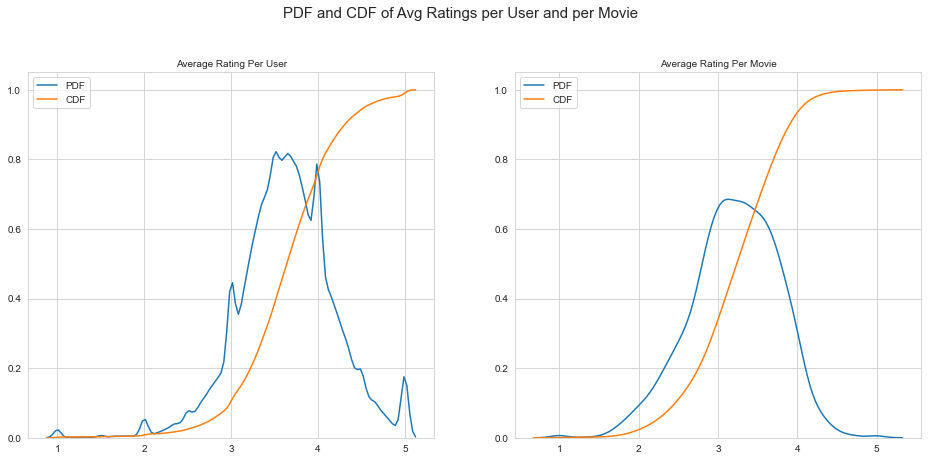

In [28]:
Global_Average_Rating = sparse_train.sum()/sparse_train.count_nonzero()
print("Global Average Rating {}".format(Global_Average_Rating))

def averageRatings(sparse_mat, if_user):
    ax = 1 if if_user else 0
    sum_ratings = sparse_mat.sum(axis = ax).A1  #axis wise sum of ratings(either user or movie)
    no_ratings = (sparse_mat!=0).sum(axis = ax).A1
    rows, cols = sparse_mat.shape
    averageRatings = {i: sum_ratings[i]/no_ratings[i] for i in range(rows if if_user else cols) if no_ratings[i]!=0}
    return averageRatings

avg_Rating_User = averageRatings(sparse_train, True)
print("Average rating of user 2894 = {}".format(np.round(avg_Rating_User[2894],2)))

avg_Rating_Movie = averageRatings(sparse_train, False)
print("Average rating of movie 4500 = {}".format(np.round(avg_Rating_Movie[4500],2)))


#Plots for PDF and CDF of avrage ratings of Users and Movies
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 7))
fig.suptitle('PDF and CDF of Avg Ratings per User and per Movie', fontsize=15)

user_average = [user for user in avg_Rating_User.values()]
sns.distplot(user_average, hist = False, ax = axes[0], label = "PDF")
sns.kdeplot(user_average, cumulative = True, ax = axes[0], label = "CDF")
axes[0].set_title("Average Rating Per User", fontsize=10)
axes[0].tick_params(labelsize = 10)
axes[0].legend(loc='upper left', fontsize = 10)

movie_average = [movie for movie in avg_Rating_Movie.values()]
sns.distplot(movie_average, hist = False, ax = axes[1], label = "PDF")
sns.kdeplot(movie_average, cumulative = True, ax = axes[1], label = "CDF")
axes[1].set_title("Average Rating Per Movie", fontsize=10)
axes[1].tick_params(labelsize = 10)
axes[1].legend(loc='upper left', fontsize = 10)

plt.subplots_adjust(wspace=0.2, top=0.85)
plt.show()

### Cold Start Problem

#### Cold Start Problem with Users and Movies

In [29]:
total_unique_users = len(np.unique(data["CustID"]))
unique_users_with_ratings = len(avg_Rating_User)
users_no_ratings = total_unique_users - unique_users_with_ratings
                  
print("Total number of Users = {}".format(total_unique_users))
print("Number of Users with ratings= {}".format(unique_users_with_ratings))
print("Number of Users with no ratings = {}({}%)".format(users_no_ratings, 
                                                         np.round((users_no_ratings/total_unique_users)*100), 2))
print("*"*100)

total_unique_movies = len(np.unique(data["MovieID"]))
movies_with_ratings = len(avg_Rating_Movie)
movies_no_ratings = total_unique_movies - movies_with_ratings
                  
print("Total number of Movies = {}".format(total_unique_movies))
print("Number of Movies with ratings = {}".format(movies_with_ratings))
print("Number of Movies with no ratings = {}({}%)".format(movies_no_ratings, 
                                                          np.round((movies_no_ratings/total_unique_movies)*100), 2))

Total number of Users = 474062
Number of Users with ratings= 393933
Number of Users with no ratings = 80129(17.0%)
****************************************************************************************************
Total number of Movies = 4711
Number of Movies with ratings = 4605
Number of Movies with no ratings = 106(2.0%)


## 4. Computing Similarity Matrices

### 4.1 Computing User-User Similarity Matrix

Calculating User User Similarity Matrix requires huge Computing Power and lots of time

In [6]:
def User_User_Similarity(sparseMatrix, top = 100):
    #List non zero elements from sparse matrix
    row_index, col_index = sparseMatrix.nonzero()
#     print(len(row_index),len(col_index))
    rows = np.unique(row_index)
#     print(rows[:top])
    similar_matrix = np.zeros(63400).reshape(634,100) # 634*100 = 61700. As we are building similarity matrix only 
    #for top 100 most similar users.
    for row in rows[:top]:
        similarity = cosine_similarity(sparseMatrix.getrow(row), sparseMatrix).ravel()
        indices = similarity.argsort()[-top:]
        top100_similar = similarity[indices]
        similar_matrix[row] = top100_similar
    return similar_matrix

user_similarity_matrix = User_User_Similarity(sparse_train, 100)

21582072 21582072


In [7]:
user_similarity_matrix.shape

(634, 100)

Computation of user-user similarity matrix is impossible if computational power is limited. On the other hand, if we try to reduce the dimension say by truncated SVD then it would take even more time because truncated SVD creates dense matrix and amount of multiplication for creation of user-user similarity matrix would increase dramatically.<br>

So, the following qeustions needs to be answered:<br>

1. 
__Is there any other way to compute user-user similarity???__<br><br>We maintain a binary Vector for users, which tells us whether we already computed similarity for this user or not..<br><br>
or<br><br>Compute top (let's just say, 1000) most similar users for this given user, and add this to our datastructure, so that we can just access it(similar users) without recomputing it again. <br><br>

2. 
__If it is already computed__<br><br>Just get it directly from our datastructure, which has that information. In production time, We might have to recompute similarities, if it is computed a long time ago. Because user preferences changes over time. If we could maintain some kind of Timer, which when expires, we have to update it ( recompute it ). <br><br>

3. 
__Which datastructure to use:__<br><br>It is purely implementation dependant.
One simple method is to maintain a **Dictionary Of Dictionaries**.<br><br>

key    :    userid<br>
value  :    Again a dictionary<br>
            key   : Similar User<br>
            value: Similarity Value

### 4.2 Computing Movie-Movie Similarity Matrix

In [8]:
if not os.path.isfile("temp_files/movie_similarity.npz"):
    movie_similarity = cosine_similarity(sparse_train.T, dense_output = False)
    sparse.save_npz("temp_files/movie_similarity.npz", movie_similarity)
else:
    movie_similarity = sparse.load_npz("temp_files/movie_similarity.npz")
    
print("Dimension of Matrix = {}".format(movie_similarity.shape))

Dimension of Matrix = (9211, 9211)


Let's pick random movie and check it's top 10 most similar movies.

In [9]:
movie_ids = np.unique(movie_similarity.nonzero()) #we take only movies that has atleast one similar movie
similar_movies_dict = {}
for movie in movie_ids:
    sim_movies_10 = np.argsort(-movie_similarity[movie].toarray().ravel())[0:10]
    similar_movies_dict[movie] = sim_movies_10 #For a movie stores the top 10 similar movies
    
movie_titles_df = pd.read_csv("../data_folder/movie_titles.csv",sep = ",", header = None, 
                names=['MovieID', 'Year_of_Release', 'Movie_Title'], index_col = "MovieID", encoding = "iso8859_2")

In [14]:
movie_titles_df.head()

,Year_of_Release,Movie_Title
MovieID,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


Similar Movies to: __Open Hearts__

In [110]:
movie_id = 4501

print("Name of the movie -------> "+str(movie_titles_df.loc[movie_id][1]))
print("Number of ratings by users for movie {} is {}".format(movie_titles_df.loc[movie_id][1],
                                                             sparse_train[:,movie_id].getnnz()))
print("Number of similar movies to {} is {}".format(movie_titles_df.loc[movie_id][1],
                                                             movie_similarity[movie_id].count_nonzero()))


Name of the movie -------> Open Hearts
Number of ratings by users for movie Open Hearts is 392
Number of similar movies to Open Hearts is 4574


In [111]:
movie_titles_df.loc[similar_movies_dict[movie_id][:10]]

,Year_of_Release,Movie_Title
MovieID,,
4501,2002.0,Open Hearts
6396,2003.0,Lilya 4-Ever
8294,2003.0,Remember Me
6584,2003.0,Zelary
5467,2004.0,Intimate Strangers
7342,2004.0,The Green Butchers
8412,2004.0,Springtime in a Small Town
7542,2004.0,Strayed
8994,2004.0,A Fond Kiss


I have done a quick google search on these movies and almost all of them belong to genre : Drama, Romance etc.that means it might have ratings from some similar group of users with similar likings<br>
It seems that Movie-Movie similarity is working good enough.

## 5. Machine Learning Models

#### Creating Sample Sparse Matrix

In [144]:
def sample_sparse_matrix(sparseMatrix, n_users, n_movies):
    users, movies, ratings = sparse.find(sparseMatrix)
    unique_users = np.unique(users)
    unique_movies = np.unique(movies)
    
    np.random.seed(15)
    user_random = np.random.choice(unique_users, n_users, replace = False)
    movie_random = np.random.choice(unique_movies, n_movies, replace = False)
    masked = np.logical_and(np.isin(users, user_random), np.isin(movies, movie_random))

    sparse_sample = sparse.csr_matrix((ratings[masked], (users[masked], movies[masked])), 
                                                     shape = (max(user_random)+1, max(movie_random)+1))
    sparse.save_npz(path, sparse_sample)
    return sparse_sample



path = "temp_files/sample_sparse_train.npz"
if not os.path.isfile(path):
    train_sample_sparse = sample_sparse_matrix(sparse_train, 4000, 400)
else:
    train_sample_sparse = sparse.load_npz(path)
    
path = "temp_files/sample_sparse_test.npz"
if not os.path.isfile(path):
    test_sample_sparse = sample_sparse_matrix(sparse_test, 2000, 200)
else:
    test_sample_sparse = sparse.load_npz(path)
        
print("Shape of Train Sample Sparse Matrix = "+str(train_sample_sparse.shape))
print("Shape of Test Sample Sparse Matrix = "+str(test_sample_sparse.shape))

Shape of Train Sample Sparse Matrix = (2649060, 9210)
Shape of Test Sample Sparse Matrix = (2648369, 9211)


In [146]:
print("No of ratings in Our Sampled train matrix is : ",train_sample_sparse.count_nonzero())
print("No of ratings in Our Sampled test matrix is : ",test_sample_sparse.count_nonzero())

No of ratings in Our Sampled train matrix is :  22280
No of ratings in Our Sampled test matrix is :  1204


####  Finding Global average of all movie ratings, Average rating per user, and Average rating per movie

In [161]:
global_average_rating_sample = train_sample_sparse.sum()/train_sample_sparse.count_nonzero()
print("Global Average Rating {}".format(Global_Average_Rating))
sample_avg_rating_user = averageRatings(train_sample_sparse, True)
print("Average rating of user 1206 = {}".format(np.round(avg_rating_sample_user[1206],2)))
sample_avg_rating_movie = averageRatings(train_sample_sparse, False)
print("Average rating of movie 4515 = {}".format(np.round(avg_rating_sample_movie[4515],2)))

print("*"*100)

global_average_rating_sample_test = test_sample_sparse.sum()/test_sample_sparse.count_nonzero()
print("Global Average Rating {}".format(Global_Average_Rating))
sample_avg_rating_user_test = averageRatings(test_sample_sparse, True)
print("Average rating of user 1206 = {}".format(np.round(avg_rating_sample_user[1206],2)))
sample_avg_rating_movie_test = averageRatings(test_sample_sparse, False)
print("Average rating of movie 4515 = {}".format(np.round(avg_rating_sample_movie[4515],2)))

Global Average Rating 3.686310592459605
Average rating of user 1206 = 3.67
Average rating of movie 4515 = 3.45
****************************************************************************************************
Global Average Rating 3.686310592459605
Average rating of user 1206 = 3.67
Average rating of movie 4515 = 3.45


## 6. Featurizing data for regression problem


<b>Features in Data:</b><br>
<div style = "background-color:#B1E9A4;margin-left:10px">
    
1. ID of a User(User_ID)
2. ID of a Movie(Movie_ID)
3. Global Average Rating(Global_Average)
4. Ratings given to this Movie by top 5 similar users with this User (sim_UR1, sim_UR2, sim_UR3, sim_UR4, sim_UR5)  
5. Ratings given by this User to top 5 similar movies with this Movie (sim_MR1, sim_MR2, sim_MR3, sim_MR4, sim_MR5)
6. Average Rating of this User(User_Average)
7. Average Rating of this Movie(Movie_Average)
8. Rating given by this User to this Movie(Rating)

</div>

In [173]:
def create_data(U,M,R,path,mode):
    with open(path, mode = "w") as data:
        count = 0
        if(mode == 'train'):
                global_avg_r = global_average_rating_sample
                avg_r_mov = sample_avg_rating_movie
                avg_r_usr = sample_avg_rating_user
                sample_sparse = train_sample_sparse
        else:
                global_avg_r = global_average_rating_sample_test
                avg_r_mov = sample_avg_rating_movie_test
                avg_r_usr = sample_avg_rating_user_test
                sample_sparse = test_sample_sparse
                
        for user, movie, rating in zip(U, M, R): 
            row = []
            row.append(user)
            row.append(movie)
           
            row.append(global_avg_r) #appending global average rating
            
            #Ratings given to "movie" by top 5 similar users with "user".
            similar_users = cosine_similarity(sample_sparse[user], sample_sparse).ravel()
            similar_users_indices = np.argsort(-similar_users)[1:]
            similar_users_ratings = sample_sparse[similar_users_indices, movie].toarray().ravel()
            top_similar_user_ratings = list(similar_users_ratings[similar_users_ratings != 0][:5])
            top_similar_user_ratings.extend([avg_r_mov[movie]]*(5-len(top_similar_user_ratings)))
            
            #above line means that if top 5 ratings are not available then rest of the ratings will be filled by global"movie"
            #average rating. Let say only 3 out of 5 ratings are available then rest 2 will be global"movie" average rating.
            row.extend(top_similar_user_ratings)

            #Ratings given by "user" to top 5 similar movies with "movie".
            similar_movies = cosine_similarity(sample_sparse[:,movie].T, sample_sparse.T).ravel()
            similar_movies_indices = np.argsort(-similar_movies)[1:]
            similar_movies_ratings = sample_sparse[user, similar_movies_indices].toarray().ravel()
            top_similar_movie_ratings = list(similar_movies_ratings[similar_movies_ratings != 0][:5])
            top_similar_movie_ratings.extend([avg_r_usr[user]]*(5-len(top_similar_movie_ratings)))
            
            #above line means that if top 5 ratings are not available then rest of the ratings will be filled by "user" average
            #rating. Let say only 3 out of 5 ratings are available then rest 2 will be "user" average rating.
            row.extend(top_similar_movie_ratings)

            #Appending "user" average, "movie" average & rating of "user""movie".
            row.append(avg_r_usr[user])
            row.append(avg_r_mov[movie])
            row.append(rating)

            #Converting rows and appending them as comma separated values to csv file.
            data.write(",".join(map(str, row)))
            data.write("\n")

            
sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(train_sample_sparse)
sample_test_users, sample_test_movies, sample_test_ratings = sparse.find(test_sample_sparse)


if not os.path.isfile("temp_files/train_Regression.csv"):
    create_data(sample_train_users,sample_train_movies,sample_train_ratings,"train_Regression.csv",mode = 'train')   
if not os.path.isfile("temp_files/test_Regression.csv"):
    create_data(sample_test_users, sample_test_movies, sample_test_ratings,"test_Regression.csv",mode = 'test')

In [4]:
columns =["User_ID", "Movie_ID", "Global_Average", "sim_UR1","sim_UR2", "sim_UR3", "sim_UR4", "sim_UR5", "sim_MR1",
          "sim_MR2", "sim_MR3", "sim_MR4", "sim_MR5", "User_Average", "Movie_Average", "Rating"]

trainData = pd.read_csv("temp_files/train_Regression.csv", names = columns )
testData = pd.read_csv("temp_files/test_Regression.csv", names = columns)

print(trainData.head())
print("Shape of Train DataFrame = {}".format(trainData.shape))
print("Shape of Test DataFrame = {}".format(testData.shape))
print("Number of nan Values in Train Data = "+str(trainData.isnull().sum().sum()))
print("Number of nan Values in test data = "+str(testData.isnull().sum().sum()))

   User_ID  Movie_ID  Global_Average  sim_UR1  sim_UR2  sim_UR3  sim_UR4  \
0    17451      4515        3.686311      4.0      3.0      5.0      3.0   
1    97289      4515        3.686311      3.0      3.0      4.0      3.0   
2   167410      4515        3.686311      3.0      4.0      5.0      3.0   
3   258319      4515        3.686311      3.0      5.0      3.0      3.0   
4   473233      4515        3.686311      3.0      5.0      3.0      4.0   

   sim_UR5  sim_MR1  sim_MR2  sim_MR3  sim_MR4  sim_MR5  User_Average  \
0      3.0      5.0      3.0      5.0      5.0      5.0      4.777778   
1      3.0      4.0      3.0      3.0      4.0      4.0      3.769231   
2      3.0      4.0      2.0      4.0      3.0      3.0      3.484848   
3      4.0      3.0      4.0      3.0      3.0      3.0      3.233333   
4      3.0      5.0      5.0      4.0      3.0      4.0      4.114286   

   Movie_Average  Rating  
0           3.45       5  
1           3.45       4  
2           3.45       

## 7. Preparing Data for Surprise Models

They have a separate format for TRAIN and TEST data, which will be useful for training the models like SVD, KNNBaseLineOnly....etc..,in Surprise.
http://surprise.readthedocs.io/en/stable/getting_started.html#load-dom-dataframe-py

- We can't give raw data (movie, user, rating) to train the model in Surprise library.
- We can form the trainset from a file, or from a Pandas  DataFrame. 
http://surprise.readthedocs.io/en/stable/getting_started.html#load-dom-dataframe-py 

- For test data we just have to define a tuple (user, item, rating).
- You can check out functions `all_ratings` and `build_testset` in the github repositories in this link: https://github.com/NicolasHug/Surprise/commit/86cf44529ca0bbb97759b81d1716ff547b950812

In [6]:
print(trainData[['User_ID', 'Movie_ID', 'Rating']].head(5))

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(trainData[['User_ID', 'Movie_ID', 'Rating']], reader)
trainset = data.build_full_trainset()
testset = list(zip(testData["User_ID"].values, testData["Movie_ID"].values, testData["Rating"].values))

   User_ID  Movie_ID  Rating
0    17451      4515       5
1    97289      4515       4
2   167410      4515       3
3   258319      4515       3
4   473233      4515       5


### 8. Applying Machine Learning Models

Functions we need for the rest of the Case Study:

In [180]:
# Utility Functions for Regression Models
def make_table(model_name, rmse_train, mape_train, rmse_test, mape_test):
    global error_table
    error_table = error_table.append(pd.DataFrame([[model_name, rmse_train, mape_train, rmse_test, mape_test]], columns = ["Model", "Train RMSE", "Train MAPE", "Test RMSE", "Test MAPE"]))
    error_table.reset_index(drop = True, inplace = True)
    
def error_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(abs((y_true - y_pred)/y_true))*100
    return rmse, mape

def plot_importance(model, clf):
    fig = plt.figure(figsize = (8, 6))
    ax = fig.add_axes([0,0,1,1])
    model.plot_importance(clf, ax = ax, height = 0.3)
    plt.xlabel("F Score", fontsize = 20)
    plt.ylabel("Features", fontsize = 20)
    plt.title("Feature Importance", fontsize = 20)
    plt.tick_params(labelsize = 15)
    plt.show()
    
def train_test_xgboost(x_train, x_test, y_train, y_test, model_name):
    train_result = {}
    test_result = {}
    clf = xgb.XGBRegressor(n_estimators = 100, silent = False, n_jobs  = 10)
    clf.fit(x_train, y_train)
    
    print("-"*50)
    print("TRAIN DATA")
    y_pred_train = clf.predict(x_train)
    rmse_train, mape_train = error_metrics(y_train, y_pred_train)
    print("RMSE = {}".format(rmse_train))
    print("MAPE = {}".format(mape_train))
    print("-"*50)
    train_result = {"RMSE": rmse_train, "MAPE": mape_train, "Prediction": y_pred_train}
    
    print("TEST DATA")
    y_pred_test = clf.predict(x_test)
    rmse_test, mape_test = error_metrics(y_test, y_pred_test)
    print("RMSE = {}".format(rmse_test))
    print("MAPE = {}".format(mape_test))
    print("-"*50)
    test_result = {"RMSE": rmse_test, "MAPE": mape_test, "Prediction": y_pred_test}
   
    plot_importance(xgb, clf)
    make_table(model_name, rmse_train, mape_train, rmse_test, mape_test)
    return train_result, test_result

def run_surprise(algo, trainset, testset, model_name): 
    train,test = {},{}
    algo.fit(trainset)

    #Evaluating Train Data#
    print("-"*50)
    print("TRAIN DATA")
    train_pred = algo.test(trainset.build_testset())
    train_actual, train_predicted = get_ratings(train_pred)
    train_rmse, train_mape = get_error(train_pred)
    print("RMSE = {}".format(train_rmse))
    print("MAPE = {}".format(train_mape))
    print("-"*50)
    train = {"RMSE": train_rmse, "MAPE": train_mape, "Prediction": train_predicted}  
    #Evaluating Test Data#
    print("TEST DATA")
    test_pred = algo.test(testset)
    test_actual, test_predicted = get_ratings(test_pred)
    test_rmse, test_mape = get_error(test_pred)
    print("RMSE = {}".format(test_rmse))
    print("MAPE = {}".format(test_mape))
    print("-"*50)
    test = {"RMSE": test_rmse, "MAPE": test_mape, "Prediction": test_predicted}

    make_table(model_name, train_rmse, train_mape, test_rmse, test_mape)
    return train, test


#Utility Functions for Surprise Models
def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    predicted = np.array([pred.est for pred in predictions])
    return actual, predicted

def get_error(predictions):
    actual, predicted = get_ratings(predictions)
    rmse = np.sqrt(mean_squared_error(actual, predicted)) 
    mape = np.mean(abs((actual - predicted)/actual))*100
    return rmse, mape

In [ ]:
global error_table = pd.DataFrame(columns = ["Model", "Train RMSE", "Train MAPE", "Test RMSE", "Test MAPE"])
result_train = {}
result_test = {}

my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)

### 8.1. Creating XGBoost initial Features

--------------------------------------------------
TRAIN DATA
RMSE = 0.6077078321157156
MAPE = 16.312971642056958
--------------------------------------------------
TEST DATA
RMSE = 0.5852934815123243
MAPE = 14.046779610092852
--------------------------------------------------


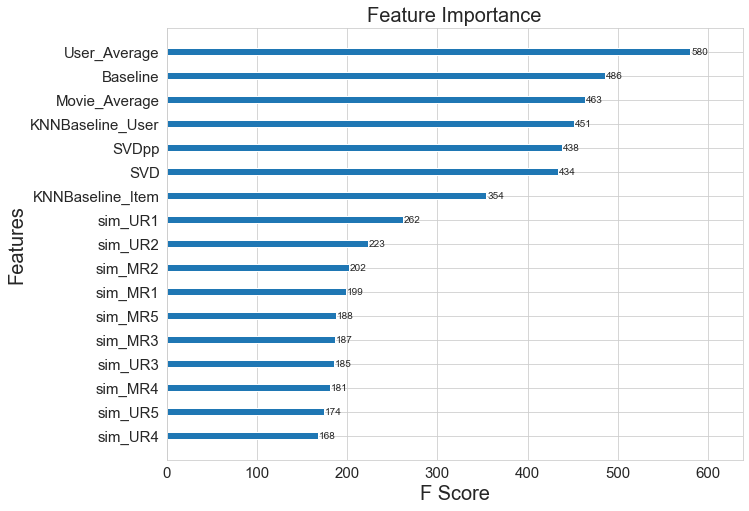

In [204]:
x_train = trainData.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)
x_test = testData.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)
y_train = trainData["Rating"]
y_test = testData["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGBoost_13")
result_train["XGBoost"] = train_result
result_test["XGBoost"] = test_result

### 8.2. Baseline features

Implemented in Surprise Library's BaselineOnly module.

There is a systematic tendency for some users to give higher ratings than others and for some items to receive
higher ratings than others. It is customary to adjust the data by accounting for these effects, which we encapsulate within the baseline estimates.

>For example, suppose that we want a baseline
estimate for the rating of the movie Dark Knight by user named Bane. Now, say that the
average rating over all movies, μ, is 3.5 stars. Furthermore, Dark Knight is better
than an average movie, so it tends to be rated 0.5 stars above the average rating. On
the other hand, Bane is a critical user, who tends to rate 0.2 stars lower than the
average. Thus, the baseline estimate for Dark Knight’s rating by Bane would be: 3.5 − 0.2 + 0.5 = 3.8 stars.



<b>A baseline estimate for an unknown rating $\large{r}_{ui}$ is
denoted by $\large\hat{r}_{ui}$</b>

> $\hat{r}_{ui} = \mu + b_u + b_i$<br><br>

Where,
- $\mu$: Average Global Ratings in training data<br>
- $b_u$ and $b_i$ indicate the observed deviations of user u and item i,respectively, from the average. 


<b> In order to estimate $b_u$ and $b_i$ one can solve the least squares optimization problem:</b>
> $ \sum_{{r}_{ui} \in R_{Train}} \left(r_{ui} - (\mu + b_u + b_i)\right)^2 + \lambda \left(b_u^2 + b_i^2 \right). \left[minimize\; b_u, b_i \right]$

Here, the first term, $  \left(r_{ui} - (\mu + b_u + b_i)\right)^2$ strives to find $b_u$s and $b_i$s that fit
the given ratings. The regularizing term   $\lambda (b_u^2 + b_i^2) $  avoids overfitting
by penalizing the magnitudes of the parameters

In [205]:
bsl_options = {"method":"sgd", "learning_rate":0.01, "n_epochs":25}

algo = BaselineOnly(bsl_options=bsl_options)
train_result, test_result = run_surprise(algo, trainset, testset, "BaselineOnly")
result_train["Baseline"] = train_result
result_test["Baseline"] = test_result

Estimating biases using sgd...
--------------------------------------------------
TRAIN DATA
RMSE = 0.8536746446318113
MAPE = 24.75855025009119
--------------------------------------------------
TEST DATA
RMSE = 1.0414588943339498
MAPE = 31.246977437903688
--------------------------------------------------


### 8.3. XGBoost Initial Features + Surprise BaselineOnly Model

##### Adding predicted ratings from Surprise BaselineOnly model to our Train and Test Dataframe

--------------------------------------------------
TRAIN DATA
RMSE = 0.6077078321157156
MAPE = 16.312971642056958
--------------------------------------------------
TEST DATA
RMSE = 0.5852934815123243
MAPE = 14.046779610092852
--------------------------------------------------


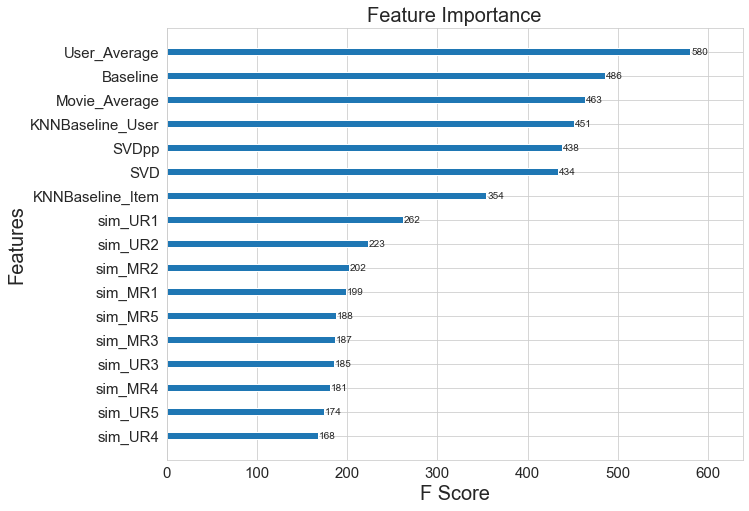

In [206]:
trainData["Baseline"] = result_train["Baseline"]["Prediction"]
testData["Baseline"] = result_test["Baseline"]["Prediction"]

x_train = trainData.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)
x_test = testData.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)
y_train = trainData["Rating"]
y_test = testData["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_BSL")
result_train["XGB_BSL"] = train_result
result_test["XGB_BSL"] = test_result

### 8.4. Neighbourhood Models

The most common approach to CF is based on neighborhood models. Its original form, which was shared by virtually all earlier CF systems, is user-user based.Such user-user methods estimate unknown ratings based on recorded ratings of like-minded users.Later, an analogous item-item approach became popular.In those methods, a rating is estimated using known ratings made by the same user on similar items.<br>
Item-item methods are more successful to providing some kind of interpretability(explaining the resason behind the predictions).This is because users are familiar with items previously preferred by them,
but do not know those allegedly like-minded users.




##### Prediction $\hat{r}_{ui}$ in case of item-item similarity.

Central to most item-item approaches is a similarity measure between items.Our goal is to predict $\hat{r}_{ui}$ --> the unobserved rating by user u for item i.We identify the k items rated by u, which are most similar to i.The most similar items for those k items is found using a similarity measure,frequently based on Pearson correlation coefficient,$\rho _{ij}$  which measures the tendency of users to rate items i and j similarly.The predicted value
of $r_{ui}$ is taken as a weighted average of the ratings of neighboring items, while adjusting for user and item effects through the baseline estimates $b_{ui}$.

$\large \hat{r}_{ui} = b_{ui} + \frac{ \sum\limits_{j \in N^k_u(i)}
\text{sim}(i, j) \cdot (r_{uj} - b_{uj})} {\sum\limits_{j \in
N^k_u(j)} \text{sim}(i, j)}$

- ${b_{ui}}$ - Baseline prediction_ of (user,movie) rating: $b_{ui} = \mu + b_u + b_i$.

- $ {N_u^k (i)}$ - Set of __K similar__ movies (neighbours) of __movie (i)__ rated by __user(u)__  
- _sim (i, j)_ - Similarity between movie __i and j__ which were rated by user 'u'. 
- $r_{uj}$ is the rating which user 'u' gives on item 'j'. $b_{uj}$ is the predicted baseline model rating of user 'u' on item 'j'.

> Generally, the similarity measure used is cosine similarity or Pearson correlation coefficient. 
But we use __shrunk Pearson-baseline correlation coefficient__, which is based on the pearsonBaseline similarity ( we take baseline predictions instead of mean rating of user/item).It is given by:
$ S_{i,j} = \large\frac{n_{ij}}{n_{ij}+\lambda_1} *\frac{\sum\limits_{i \in N^k_u(i)}(r_{ui} - b_{ui})(r_{uj} - b_{uj})}{\sqrt{\sum\limits_{i \in N^k_u(i)}(r_{ui} - b_{ui})^2 *\sum\limits_{j \in N^k_u(j)}(r_{uj} - b_{uj})^2 }}    $



##### Prediction $\hat{r}_{ui}$ in case of user-user similarity

Here ,we identify the k most similar users(neighbors) to user u.The predicted value
of $r_{ui}$ is taken as a weighted average of the ratings given by the k neighboring users to item i, while adjusting for user and item effects through the baseline estimates $b_{ui}$

$\large \hat{r}_{ui} = b_{ui} + \frac{ \sum\limits_{v \in N^k_i(u)}
\text{sim}(u, v) \cdot (r_{vi} - b_{vi})} {\sum\limits_{v
\in N^k_i(u)} \text{sim}(u, v)}$

- ${b_{ui}}$ - Baseline prediction_ of (user,movie) rating which is "$b_{ui} = \mu + b_u + b_i$".

- $ {N_i^k (u)}$ - Set of __K similar__ users (neighbours) of __user (u)__ who rated __movie(i)__  

- _sim (u, v)_ - Similarity between users __u and v__ who also rated movie 'i'. 
- $b_{vi}$ is the predicted baseline model rating of user 'v' on item 'i'.
    <br><br><br><br> 


__In Surprise , the Neighbourhood model is implemented in KNN-Baseline module__

### 8.5 Surprise KNN-Baseline with User-User.

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

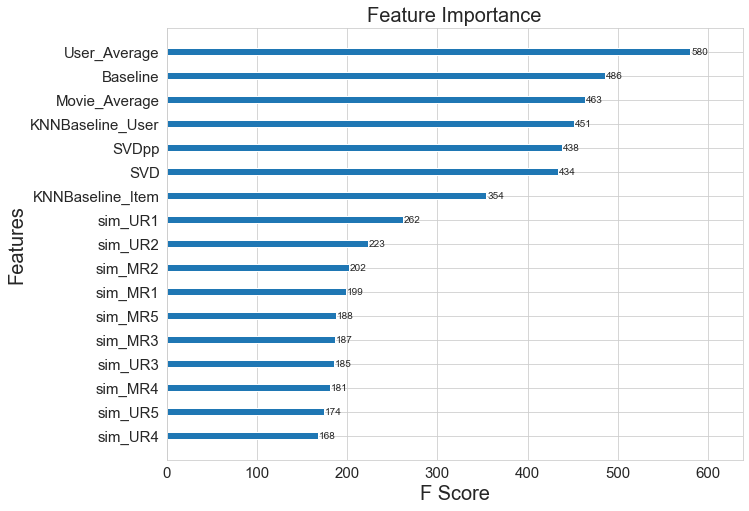

In [207]:
param_grid  = {'sim_options':{'name': ["pearson_baseline"], "user_based": [True], "min_support": [2],
                              "shrinkage": [60, 80, 80, 140]}, 'k': [5, 20, 40, 80]}
gs = GridSearchCV(KNNBaseline, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)
# best RMSE score
print(gs.best_score['rmse'])
# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

#Applying KNNBaseline User-User with best parameters
x_train = trainData.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)
x_test = testData.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)
y_train = trainData["Rating"]
y_test = testData["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_BSL")
result_train["XGB_BSL"] = train_result
result_test["XGB_BSL"] = test_result

### 8.6 Surprise KNN-Baseline with Item-Item.

In [208]:
param_grid  = {'sim_options':{'name': ["pearson_baseline"], "user_based": [False], "min_support": [2], "shrinkage": [60, 80, 80, 140]}, 'k': [5, 20, 40, 80]}

gs = GridSearchCV(KNNBaseline, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)
# best RMSE score
print(gs.best_score['rmse'])
# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

#Applying KNNBaseline Item-Item with best parameters
sim_options = {'name':'pearson_baseline', 'user_based':False, 'min_support':2, 'shrinkage':gs.best_params['rmse']['sim_options']['shrinkage']}
bsl_options = {'method': 'sgd'} 
algo = KNNBaseline(k = gs.best_params['rmse']['k'], sim_options = sim_options, bsl_options=bsl_options)
train_result, test_result = run_surprise(algo, trainset, testset, "KNNBaseline_Item")
result_train["KNNBaseline_Item"] = train_result
result_test["KNNBaseline_Item"] = test_result

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

### 8.7. XGBoost 13 Features + Surprise BaselineOnly + Surprise KNN Baseline

--------------------------------------------------
TRAIN DATA
RMSE = 0.6077078321157156
MAPE = 16.312971642056958
--------------------------------------------------
TEST DATA
RMSE = 0.5852934815123243
MAPE = 14.046779610092852
--------------------------------------------------


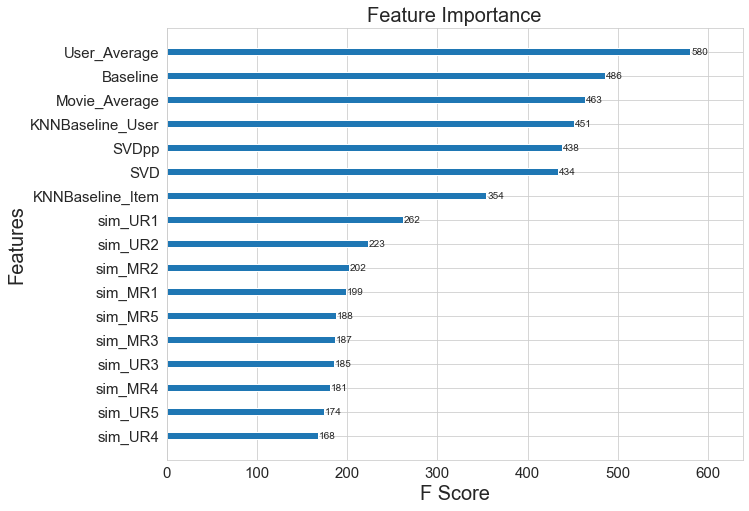

In [210]:
#Adding predicted ratings from Surprise KNN Baseline model to our Train and Test Dataframe
trainData["KNNBaseline_User"] = result_train["KNNBaseline_User"]["Prediction"]
trainData["KNNBaseline_User"] = result_train["KNNBaseline_User"]["Prediction"]
trainData["KNNBaseline_Item"] = result_train["KNNBaseline_Item"]["Prediction"]
testData["KNNBaseline_User"] = result_test["KNNBaseline_User"]["Prediction"]
testData["KNNBaseline_Item"] = result_test["KNNBaseline_Item"]["Prediction"]

x_train = trainData.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)
x_test = testData.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)
y_train = trainData["Rating"]
y_test = testData["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_BSL_KNN")
result_train["XGB_BSL_KNN"] = train_result
result_test["XGB_BSL_KNN"] = test_result

### 8.8.Latent Factor Models
These models uses Matrix Factorization(using SVD)

Latent Factor models are models that are induced by singular value decomposition (SVD) on the user-item ratings matrix.They introduce an alternative approach to collaborative filtering with the goal to uncover latent features that explain observed ratings. Sparsity and scalability are the two biggest challenges for standard CF method,so Matrix factorization comes with a more advanced method that decompose the original sparse matrix to low-dimensional matrices with latent factors/features and less sparsity.

Beside solving the issues of sparsity and scalability, there’s an intuitive explanation of why we need low-dimensional matrices to represent users’ preference.A user may give good ratings to movies Iron Man, Source Code, and X-men. They are not necessarily three separate opinions but shows that this users might be in favor of Sci-Fi movies and there may be many more Sci-Fi movies that this user would like. Unlike specific movies, latent features is expressed by higher-level attributes, and Sci-Fi category is one of latent features in this case. 

A typical model associates each user u with a user-factors vector $p_u \in R^f$ , and each item i with an item-factors vector $q_i ∈ R^f$ . The prediction is done by taking an inner product: $\large \hat r_{ui} = b_{ui} + q^T_i.p_u$ where $\large b_{ui} = \mu + b_u + b_i $ and

__If user u is unknown, then the bias $b_u$ and the factors $p_u$ are assumed to be zero. The same applies for item i with $b_i$ and $q_i$.__<br><br><br>


We solve the Optimization Problem below to find $b_u, b_i, q_i, p_u$<br>

$\large \sum_{r_{ui} \in R_{train}} \left(r_{ui} - \hat{r}_{ui} \right)^2 +
\lambda\left(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2\right) \left[minimize\; b_u, b_i, q_i, p_u \right]$
<br><br><br>


In [211]:
param_grid  = {'n_factors': [5,7,10,15,20,25,35,50,70,90]}   

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)
# best RMSE score
print(gs.best_score['rmse'])
# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

#Applying SVD with best parameters
algo = SVD(n_factors = gs.best_params['rmse']['n_factors'], biased=True, verbose=True)
train_result, test_result = run_surprise(algo, trainset, testset, "SVD")
result_train["SVD"] = train_result
result_test["SVD"] = test_result

0.9481628180874191
{'n_factors': 5}
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
--------------------------------------------------
TRAIN DATA
RMSE = 0.8648403903254027
MAPE = 25.48916122786436
--------------------------------------------------
TEST DATA
RMSE = 1.0422019275075918
MAPE = 31.26206328713657
--------------------------------------------------


### 8.9. Matrix Factorization SVDpp with implicit feedback

Explicit Rating, is a rate given by a user to an item , like 5 stars for Intersteller. This is a direct feedback from users to show how much they like an item. Implicit Rating, suggests users preference indirectly, such as page views, clicks, purchase history, browsing history, search patterns, whether or not listen to a music track,or even mouse movements.However, such data is not available to us. However a less obvious kind of implicit data does exist within the Netflix dataset. The dataset not only tells us the rating values, but also which movies
users rate, regardless of how they rated these movies

In other words, a user implicitly tells us about her preferences by choosing to voice her opinion and
vote a rating.For this we use an  integrated model that combines the
item-item model with a latent factor model ,called <b>SVD++</b>


In this model `Prediction` $\hat{r}_{ui}$ is given by:<br>

$\large \hat{r}_{ui} = \mu + b_u + b_i + q_i^T(p_u +
\frac {\sum_{j \in I_u}y_j}{\sqrt{|I_u|}})$

Where,

 * $ {I_u}$ : the set of all items rated by user u. $|I_u|$ is a length of that set.<br>

*  ${y_j}$ : Our new set of item factors that captures implicit ratings for user u. Here,as already stated, an implicit rating describes the fact that a user u rated an item j, regardless of the rating value.<br><br>


We solve the `Optimization Problem` below to find $b_u, b_i, q_i, p_u, y_j$

$\large \sum_{r_{ui} \in R_{train}} \left(r_{ui} - \hat{r}_{ui} \right)^2 +
\lambda\left(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2 + ||y_j||^2\right).\left[minimize\; b_u, b_i, q_i, p_u, y_j \right]$<br><br>


In [212]:
param_grid = {'n_factors': [10, 30, 50, 80, 100], 'lr_all': [0.002, 0.006, 0.018, 0.054, 0.10]}

gs = GridSearchCV(SVDpp, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)
# best RMSE score
print(gs.best_score['rmse'])
# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

#Applying SVDpp with best parameters
algo = SVDpp(n_factors = gs.best_params['rmse']['n_factors'], lr_all = gs.best_params['rmse']["lr_all"], verbose=True)
train_result, test_result = run_surprise(algo, trainset, testset, "SVDpp")
result_train["SVDpp"] = train_result
result_test["SVDpp"] = test_result

0.9397527517296732
{'n_factors': 10, 'lr_all': 0.006}
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
--------------------------------------------------
TRAIN DATA
RMSE = 0.7736729809132444
MAPE = 22.332867771485194
--------------------------------------------------
TEST DATA
RMSE = 1.0420838260995462
MAPE = 31.25292576369944
--------------------------------------------------


### 8.10 XGBoost 13 Features + Surprise BaselineOnly + Surprise KNN Baseline + SVD + SVDpp

--------------------------------------------------
TRAIN DATA
RMSE = 0.6039305136392172
MAPE = 16.2138020798234
--------------------------------------------------
TEST DATA
RMSE = 0.5919728120795607
MAPE = 14.389958682646384
--------------------------------------------------


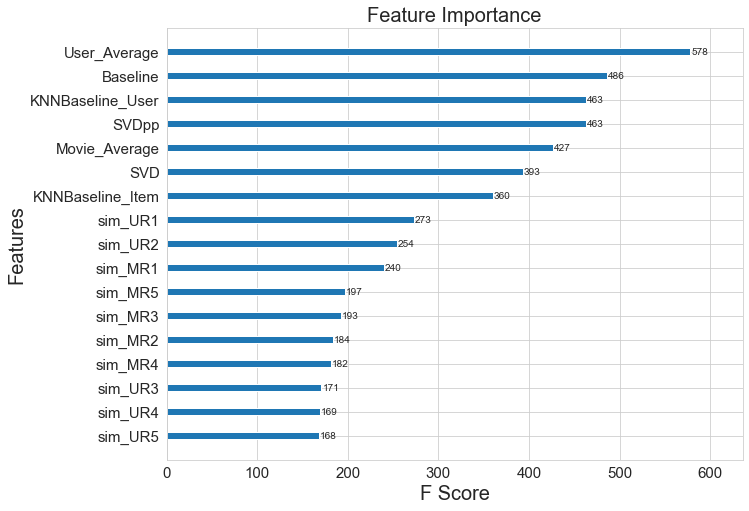

In [213]:
trainData["SVD"] = result_train["SVD"]["Prediction"]
trainData["SVDpp"] = result_train["SVDpp"]["Prediction"]

testData["SVD"] = result_test["SVD"]["Prediction"]
testData["SVDpp"] = result_test["SVDpp"]["Prediction"]

x_train = trainData.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)
x_test = testData.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)
y_train = trainData["Rating"]
y_test = testData["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_BSL_KNN_MF")
result_train["XGB_BSL_KNN_MF"] = train_result
result_test["XGB_BSL_KNN_MF"] = test_result

### 8.11 Surprise KNN Baseline + SVD + SVDpp

--------------------------------------------------
TRAIN DATA
RMSE = 0.6039305136392172
MAPE = 16.2138020798234
--------------------------------------------------
TEST DATA
RMSE = 0.5919728120795607
MAPE = 14.389958682646384
--------------------------------------------------


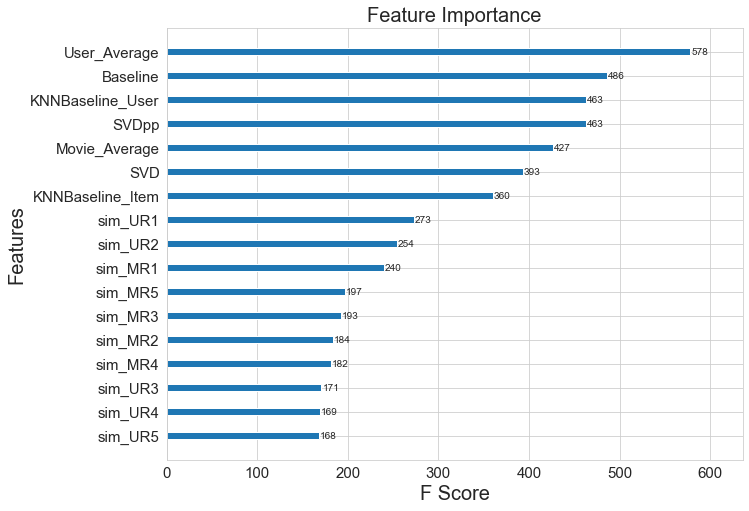

In [214]:
x_train = trainData.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)
x_test = testData.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)
y_train = trainData["Rating"]
y_test = testData["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_KNN_MF")
result_train["XGB_KNN_MF"] = train_result
result_test["XGB_KNN_MF"] = test_result

### 9. Summary

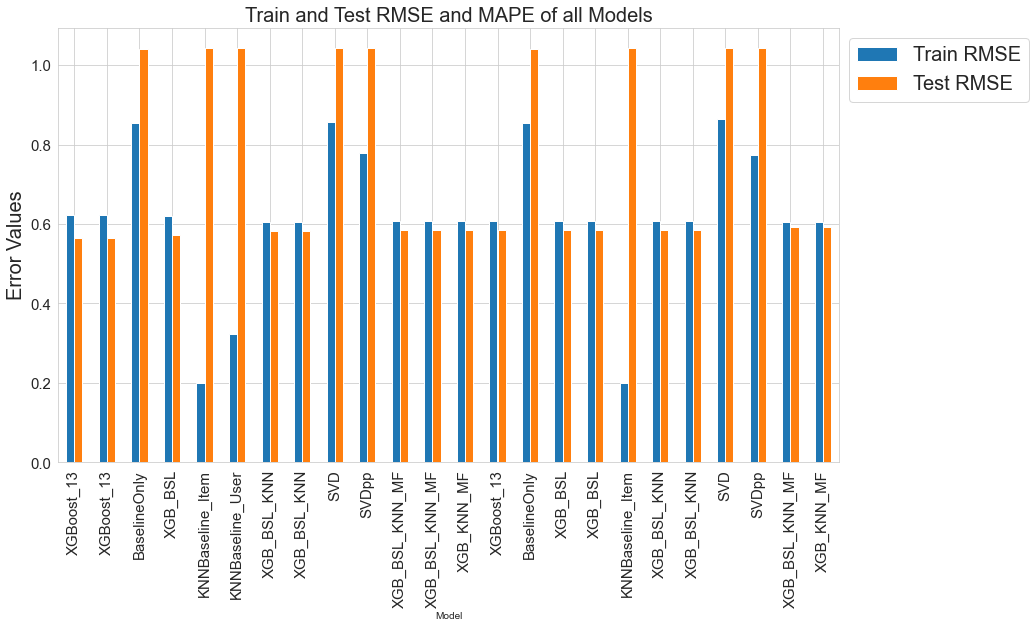

In [215]:
error_table2 = error_table.drop(["Train MAPE", "Test MAPE"], axis = 1)
error_table2.plot(x = "Model", kind = "bar", figsize = (14, 8), grid = True, fontsize = 15)
plt.title("Train and Test RMSE and MAPE of all Models", fontsize = 20)
plt.ylabel("Error Values", fontsize = 20)
plt.legend(bbox_to_anchor=(1, 1), fontsize = 20)
plt.show()

In [216]:
error_table.drop(["Train MAPE", "Test MAPE"], axis = 1).style.highlight_min(axis=0)

,Model,Train RMSE,Test RMSE
0,XGBoost_13,0.623373,0.565477
1,XGBoost_13,0.623373,0.565477
2,BaselineOnly,0.853675,1.041459
3,XGB_BSL,0.619074,0.572776
4,KNNBaseline_Item,0.200782,1.042186
5,KNNBaseline_User,0.322350,1.042186
6,XGB_BSL_KNN,0.606156,0.581689
7,XGB_BSL_KNN,0.606156,0.581689
8,SVD,0.857377,1.042162
9,SVDpp,0.777505,1.042050


# So, far our best model is SVDpp with Test RMSE of 1.067583